In [ ]:
# CS101 Black hole general relativity signatures
# Iman Wahle
# October 2019
# Autoencoder for black hole simulation dimensionality reduction
# and reconstruction

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from keras.models import Model
from keras import backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from matplotlib import pyplot as plt

Using TensorFlow backend.
/Users/imanwahle/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a release (2.7.7+) that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,


In [2]:
labels = np.zeros((9090,2))
cnt = 0
for incl in range(0,90):
    for spin in range(0,101):
        labels[cnt,:] = [incl, spin]
        cnt+=1

In [3]:
# load data 

path = "/Users/imanwahle/Desktop/CS101/"
tmp = np.load(path + "X.npy")
X = np.zeros((tmp.shape[0], tmp.shape[1], tmp.shape[2], 1))
X[:,:,:,0] = np.load(path + "X.npy")
y = labels # np.load(path + "y.npy").astype(int)
n_classes = len(np.unique(y))
X = X/np.max(X) # scale input values to [0,1]
# define training and validation sets
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.75, 
                                                    random_state=42)


In [4]:
def Encoder():
    input_img = Input(shape=(100,100,1)) 
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    shape = K.int_shape(x)
    x = Flatten()(x)
    x = Dense(500, activation='relu')(x)
    encoded = Dense(2, activation='sigmoid')(x)
    # encoded = Dense(100, activation='relu')(x)
    # encoded = Dense(10, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
    return Model(input_img, encoded) , shape

def Decoder(shape):
    input_img = Input(shape=(2,))
    x = Dense(500, activation='relu')(input_img)
    # x = Dense(500, activation='relu')(input_img)
    x = Dense(np.prod(shape[1:]), activation='relu')(x)
    x = Reshape(shape[1:])(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(input_img, decoded)

x = Input(shape=(100,100,1))

encoder,shape = Encoder()
decoder = Decoder(shape)
autoencoder = Model(x, decoder(encoder(x)))


In [5]:
autoencoder.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['mse'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 683606    
_________________________________________________________________
model_2 (Model)              (None, 100, 100, 1)       685533    
Total params: 1,369,139
Trainable params: 1,369,139
Non-trainable params: 0
_________________________________________________________________


In [6]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 8)         0         
__________

In [7]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               1500      
_________________________________________________________________
dense_4 (Dense)              (None, 1352)              677352    
_________________________________________________________________
reshape_1 (Reshape)          (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 8)         584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 16)        1168      
__________

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder8')])

Train on 2272 samples, validate on 6818 samples
Epoch 1/100
2272/2272 [==============================] - 155s 68ms/step - loss: 0.1648 - mean_squared_error: 0.0031 - val_loss: 0.1634 - val_mean_squared_error: 0.0031
Epoch 2/100
2272/2272 [==============================] - 170s 75ms/step - loss: 0.1648 - mean_squared_error: 0.0031 - val_loss: 0.1634 - val_mean_squared_error: 0.0031
Epoch 3/100
2272/2272 [==============================] - 158s 70ms/step - loss: 0.1648 - mean_squared_error: 0.0031 - val_loss: 0.1634 - val_mean_squared_error: 0.0031
Epoch 4/100
2272/2272 [==============================] - 149s 66ms/step - loss: 0.1648 - mean_squared_error: 0.0031 - val_loss: 0.1633 - val_mean_squared_error: 0.0031
Epoch 5/100
2272/2272 [==============================] - 154s 68ms/step - loss: 0.1648 - mean_squared_error: 0.0031 - val_loss: 0.1633 - val_mean_squared_error: 0.0031
Epoch 6/100
2272/2272 [==============================] - 226s 99ms/step - loss: 0.1648 - mean_squared_error: 0.0

2272/2272 [==============================] - 113s 50ms/step - loss: 0.1640 - mean_squared_error: 0.0029 - val_loss: 0.1626 - val_mean_squared_error: 0.0030
Epoch 98/100
2272/2272 [==============================] - 112s 49ms/step - loss: 0.1640 - mean_squared_error: 0.0029 - val_loss: 0.1626 - val_mean_squared_error: 0.0030
Epoch 99/100
2272/2272 [==============================] - 120s 53ms/step - loss: 0.1640 - mean_squared_error: 0.0029 - val_loss: 0.1626 - val_mean_squared_error: 0.0030
Epoch 100/100
2272/2272 [==============================] - 175s 77ms/step - loss: 0.1640 - mean_squared_error: 0.0029 - val_loss: 0.1626 - val_mean_squared_error: 0.0029


In [265]:
autoencoder.save_weights('/Users/imanwahle/Desktop' + '/aenc_weights.h5')
encoder.save_weights('/Users/imanwahle/Desktop' + '/enc_weights.h5')
decoder.save_weights('/Users/imanwahle/Desktop' + '/dec_weights.h5')


# Reconstruction

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

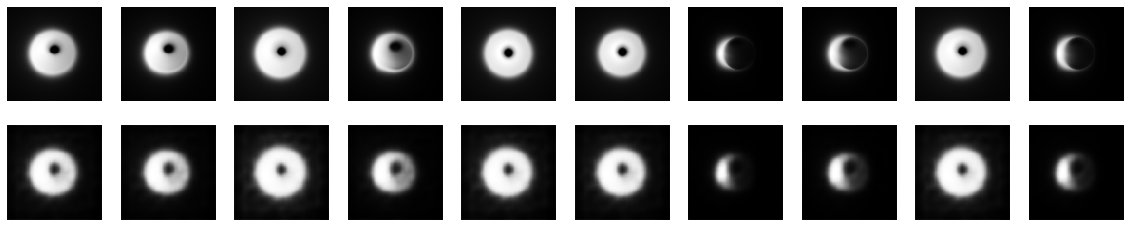

In [321]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
# plt.savefig("autoencoder_reconstruction.png", transparent=True)

In [224]:
encoded_imgs_test = encoder.predict(x_test)


In [225]:
encoded_imgs_test.shape

(6818, 2)

In [226]:
encoded_imgs_test[:10,:]

array([[0.9780889 , 0.3131069 ],
       [0.9955988 , 0.58119416],
       [0.99107224, 0.4455503 ],
       [0.99863523, 0.8303062 ],
       [0.9610221 , 0.28453752],
       [0.99806744, 0.75340754],
       [0.9971641 , 0.6701603 ],
       [0.5337582 , 0.12584178],
       [0.75804776, 0.15366115],
       [0.99789256, 0.7442534 ]], dtype=float32)

In [227]:
print np.min((encoded_imgs_test[:,0]))
print np.max((encoded_imgs_test[:,0]))
print np.min((encoded_imgs_test[:,1]))
print np.max((encoded_imgs_test[:,1]))

0.31372043
0.9994373
0.0989395
0.93063223


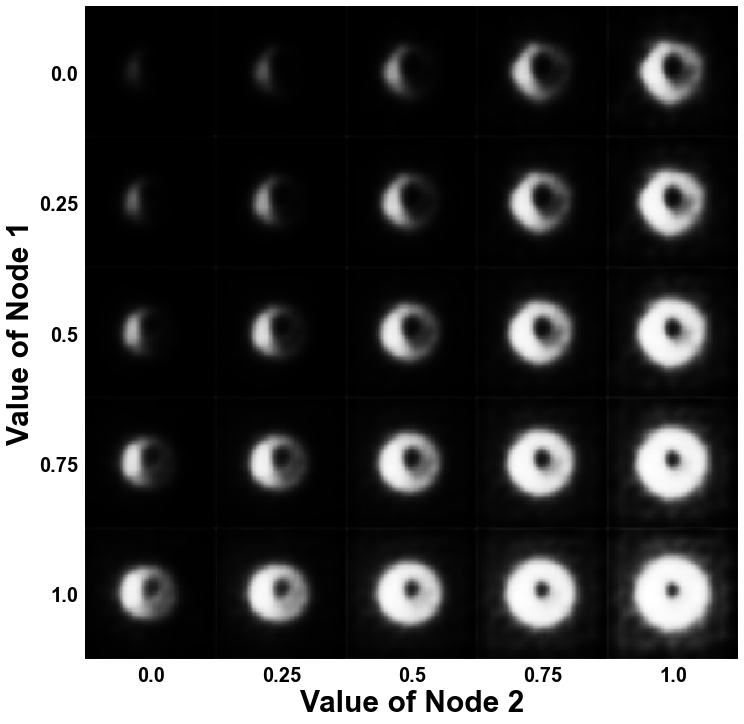

In [347]:
# from PIL import Image
cnt=0
steps = np.arange(5)/4.
w = 100
bigpic = np.zeros((w*len(steps),w*len(steps)))
for n1i,n1 in enumerate(steps):
    for n2i,n2 in enumerate(steps):
        test_encoded = np.zeros((1,2))
        test_encoded[0,:] = [n1,n2]
        test_decoded = decoder.predict(test_encoded)

        bigpic[n1i*w:n1i*w+w, n2i*w:n2i*w+w] = test_decoded.reshape(100,100)

        
fig, ax = plt.subplots(figsize=(12,12))
plt.imshow(bigpic)
plt.xlabel("Value of Node 2",fontweight='extra bold', fontsize=30,color='black')
plt.ylabel("Value of Node 1",fontweight='extra bold', fontsize=30,color='black')
plt.xticks(np.arange(len(steps))*100+50)
plt.yticks(np.arange(len(steps))*100+50)
ax.set_xticklabels(steps,fontweight='extra bold',fontsize=20,color='black')
ax.set_yticklabels(steps,fontweight='extra bold',fontsize=20,color='black')
ax.grid(False)
# plt.title("Decoding Across 2-D Encoding Space",fontweight='extra bold',fontsize=30)
plt.show()
#plt.savefig("2node_encoding_autoencoder.png", transparent=True)

# Artificial Generations

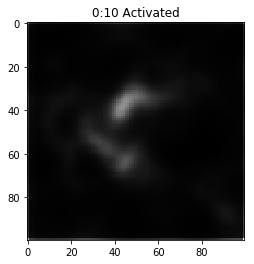

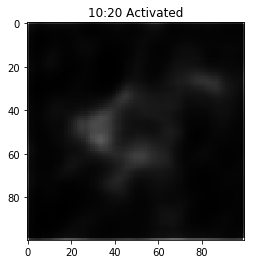

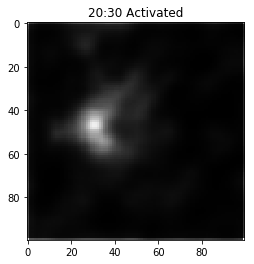

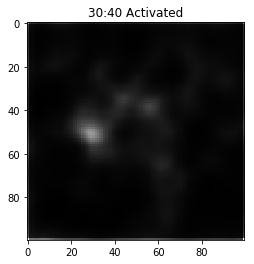

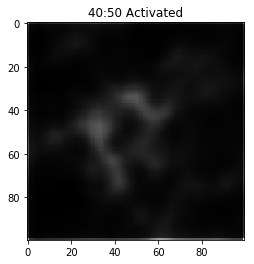

In [84]:
for n in range(5):
    test_encoded = np.zeros((1,50))
    test_encoded[0,10*n:10*(n+1)] = 1
    test_decoded = decoder.predict(test_encoded)
    plt.imshow(test_decoded.reshape(100,100))
    plt.title(str(10*n) + ":" + str(10*(n+1)) + " Activated")
    plt.show()

# Cluster on encoded representation

In [325]:
from sklearn.cluster import KMeans

In [326]:
x_train_pred = encoder.predict(x_train)
x_test_pred = encoder.predict(x_test)

In [327]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(x_train_pred)
C_train = kmeans.predict(x_train_pred)
C_test = kmeans.predict(x_test_pred)

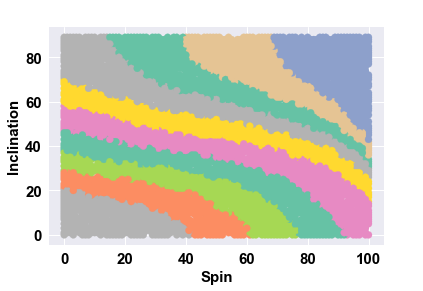

In [348]:
plt.scatter(y_test[:,1], y_test[:,0], c=C_test, cmap="Set2")#sns.color_palette("Set2", n_colors=10))
plt.title("Kmeans Clustering on 2D Encoding, K=10",fontweight='extra bold',fontsize=20,color='w')
plt.xlabel('Spin',fontweight='extra bold',fontsize=15,color='black')
plt.ylabel('Inclination',fontweight='extra bold',fontsize=15,color='black')
plt.xticks(fontweight='extra bold',fontsize=15,color='black')
plt.yticks(fontweight='extra bold',fontsize=15,color='black')
# plt.savefig("2node_clustering_autoencoder.png", transparent=True)
plt.show()